# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data_tools.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=2,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=7,
          negative_sample=True,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          regression=False,
          scheduler='cosine',
          stride=192,
          tokenizer_version=2,
          train=True,
          train_folds=[0, 1, 2, 3, 4, 5, 6, 

In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [7]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [9]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, pred_scores = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, pred_scores)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}": epoch + 1,
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                os.path.join(
                    Paths.MODEL_OUTPUT_PATH,
                    f"{config.model.replace('/', '_')}_fold_{fold}_best.pth",
                ),
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    predictions = softmax(torch.tensor(predictions))
    _, pred_scores = torch.max(predictions, dim=1)
    valid_fold["pred_score"] = pred_scores

    for i in range(config.num_classes):
        valid_fold[f"score_prob_{i}"] = predictions[:, i]

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 126/126 [00:20<00:00,  6.18valid_batch/s]


Epoch 1 - avg_train_loss: 1.1815  avg_val_loss: 1.0896  time: 218s
Epoch 1 - Score: 0.6921
Epoch 1 - Save Best Score: 0.6921 Model


Validating Fold 0: 100%|██████████| 126/126 [00:20<00:00,  6.19valid_batch/s]


Epoch 2 - avg_train_loss: 0.9532  avg_val_loss: 1.0114  time: 219s
Epoch 2 - Score: 0.7680
Epoch 2 - Save Best Score: 0.7680 Model
========== Fold: 0 result ==========
Score: 0.7680
========== Fold: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 122/122 [00:19<00:00,  6.18valid_batch/s]


Epoch 1 - avg_train_loss: 1.1472  avg_val_loss: 1.0990  time: 219s
Epoch 1 - Score: 0.7309
Epoch 1 - Save Best Score: 0.7309 Model


Validating Fold 1: 100%|██████████| 122/122 [00:19<00:00,  6.18valid_batch/s]


Epoch 2 - avg_train_loss: 0.9293  avg_val_loss: 1.0126  time: 219s
Epoch 2 - Score: 0.7528
Epoch 2 - Save Best Score: 0.7528 Model
========== Fold: 1 result ==========
Score: 0.7528
========== Fold: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.16valid_batch/s]


Epoch 1 - avg_train_loss: 1.1502  avg_val_loss: 1.1468  time: 222s
Epoch 1 - Score: 0.6214
Epoch 1 - Save Best Score: 0.6214 Model


Validating Fold 2: 100%|██████████| 109/109 [00:17<00:00,  6.22valid_batch/s]


Epoch 2 - avg_train_loss: 0.9206  avg_val_loss: 1.1501  time: 221s
Epoch 2 - Score: 0.6613
Epoch 2 - Save Best Score: 0.6613 Model
========== Fold: 2 result ==========
Score: 0.6613
========== Fold: 3 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 58/58 [00:09<00:00,  6.20valid_batch/s]


Epoch 1 - avg_train_loss: 1.1450  avg_val_loss: 1.1589  time: 228s
Epoch 1 - Score: 0.4720
Epoch 1 - Save Best Score: 0.4720 Model


Validating Fold 3: 100%|██████████| 58/58 [00:09<00:00,  6.27valid_batch/s]


Epoch 2 - avg_train_loss: 0.9308  avg_val_loss: 0.9962  time: 229s
Epoch 2 - Score: 0.5960
Epoch 2 - Save Best Score: 0.5960 Model
========== Fold: 3 result ==========
Score: 0.5960
========== Fold: 4 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4: 100%|██████████| 154/154 [00:24<00:00,  6.17valid_batch/s]


Epoch 1 - avg_train_loss: 1.1914  avg_val_loss: 1.0194  time: 214s
Epoch 1 - Score: 0.7027
Epoch 1 - Save Best Score: 0.7027 Model


Validating Fold 4: 100%|██████████| 154/154 [00:24<00:00,  6.23valid_batch/s]


Epoch 2 - avg_train_loss: 0.9583  avg_val_loss: 0.9704  time: 213s
Epoch 2 - Score: 0.6871
========== Fold: 4 result ==========
Score: 0.7027
========== Fold: 5 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 5: 100%|██████████| 82/82 [00:13<00:00,  6.18valid_batch/s]


Epoch 1 - avg_train_loss: 1.1536  avg_val_loss: 1.1755  time: 225s
Epoch 1 - Score: 0.6528
Epoch 1 - Save Best Score: 0.6528 Model


Validating Fold 5: 100%|██████████| 82/82 [00:13<00:00,  6.24valid_batch/s]


Epoch 2 - avg_train_loss: 0.9278  avg_val_loss: 1.2387  time: 226s
Epoch 2 - Score: 0.6930
Epoch 2 - Save Best Score: 0.6930 Model
========== Fold: 5 result ==========
Score: 0.6930
========== Fold: 6 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 6: 100%|██████████| 96/96 [00:15<00:00,  6.17valid_batch/s]


Epoch 1 - avg_train_loss: 1.1256  avg_val_loss: 1.2225  time: 222s
Epoch 1 - Score: 0.6814
Epoch 1 - Save Best Score: 0.6814 Model


Validating Fold 6: 100%|██████████| 96/96 [00:15<00:00,  6.14valid_batch/s]


Epoch 2 - avg_train_loss: 0.9331  avg_val_loss: 1.1659  time: 224s
Epoch 2 - Score: 0.7337
Epoch 2 - Save Best Score: 0.7337 Model
========== Fold: 6 result ==========
Score: 0.7337
========== CV ==========
Score: 0.7387


In [13]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

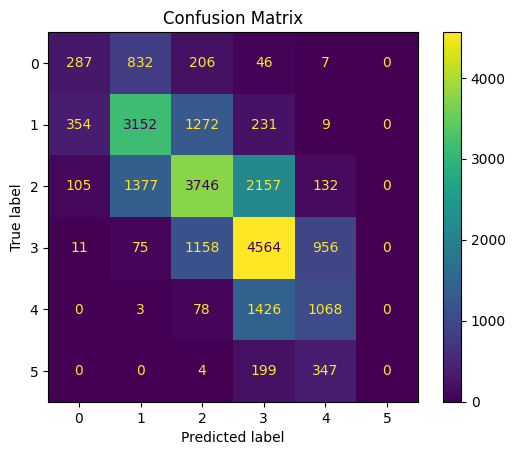

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [16]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁█
eval/eval_epoch_f1,▁█
eval/eval_epoch_f2,▁█
eval/eval_epoch_f3,▁█
eval/eval_epoch_f4,▁█
eval/eval_epoch_f5,▁█
eval/eval_epoch_f6,▁█
eval/eval_loss_f0,█▁
eval/eval_loss_f1,█▁
eval/eval_loss_f2,▁█
